# Faces 3D

#### Scopo del progetto: Acquisire modelli 2.5 D di volti umani con tecnologie di fascia consumer
#### Strumentazione: Intel® RealSense™ Depth Camera D435, supporto rigido per 2 camere, cavalletto


## Intel® RealSense™ Depth Camera D435

![](camera.png)

#### Sistema Simple Stereo:
* Piani immagine coplanari
* Posizioni dei sistemi di riferimento delle camere note: displacement solo lungo asse X
* Parametri intrinseci delle camere note (lunghezza focale, posizione centro ottico)
* Matching tra immagine di sinistra e di destra avviene su scanlines orizzontali
* La depth (Z) è inversamente proporzionale alla disparità

![](SStereo.png)
## Moduli della camera D435
![](modules.jpg)

* I due sensori (camere) acquisiscono nell'infrarosso la scena effettuando poi il matching come qualsiasi sistema di acquisizione stereo
* Il matching viene ulteriormente migliorato utilizzando un proiettore IR: quest'ultimo proietta un pattern non casuale sulla scena che viene utilizzato per dare texture laddove non ci sia e come illuminante in assenza di luce naturale (che contiene anch'essa una componente IR).


#### Nota bene: La depth non viene ricostruita utilizzando un sensore basato su Time of flight, tenere quindi in considerazione le problematiche per l'esecuzione del matching tra le due immagini (left e right) relative a:
1. Illuminazione
2. Texture
3. Riflessi

# Esempio di acquisizione con/senza pattern IR

In [22]:
import pyrealsense2 as rs
import numpy as np
import cv2

def view(emitter=True): 
    # Configure depth and color streams
    pipeline = rs.pipeline()
    config = rs.config()

    # Get device product line for setting a supporting resolution
    pipeline_wrapper = rs.pipeline_wrapper(pipeline)
    pipeline_profile = config.resolve(pipeline_wrapper)
    device = pipeline_profile.get_device()
    depth_sensor = device.query_sensors()[0]
    if emitter:
        depth_sensor.set_option(rs.option.emitter_enabled, 1)
    else:
        depth_sensor.set_option(rs.option.emitter_enabled, 0)


    config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)
    config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)

    # Start streaming
    pipeline.start(config)

    try:
        while True:

            # Wait for a coherent pair of frames: depth and color
            frames = pipeline.wait_for_frames()
            depth_frame = frames.get_depth_frame()
            color_frame = frames.get_color_frame()
            if not depth_frame or not color_frame:
                continue

            # Convert images to numpy arrays
            depth_image = np.asanyarray(depth_frame.get_data())
            color_image = np.asanyarray(color_frame.get_data())

            # Apply colormap on depth image (image must be converted to 8-bit per pixel first)
            depth_colormap = cv2.applyColorMap(cv2.convertScaleAbs(depth_image, alpha=0.03), cv2.COLORMAP_JET)

            depth_colormap_dim = depth_colormap.shape
            color_colormap_dim = color_image.shape

            images = np.hstack((color_image, depth_colormap))

            # Show images
            cv2.namedWindow('RealSense', cv2.WINDOW_AUTOSIZE)
            cv2.imshow('RealSense', images)
            a = cv2.waitKey(10)
            if a==27:
                cv2.destroyWindow("RealSense")
                break

    finally:

        # Stop streaming
        pipeline.stop()

In [23]:
view(True)

# Point-cloud
È un insieme di punti nello spazio ognuno dei quali definiti nella loro posizione secondo gli assi X, Y, Z in un determinato sistema di coordinate e caratterizzati da eventuali valori di intensità (RGB o altre lunghezze scalari.) ad essi associati.

<div width="100%" align="center">
<img src="point_cloud.png" width="800px">
</div>

# Come costruire la point-cloud partendo dalla depth-map
Factory function to create a pointcloud from a depth image and a camera. Given depth value $d$ at $(u, v)$ image coordinate, the corresponding 3D point is:

$z = d / depthScale$

$x = (u - c_x) * z / f_x$

$y = (v - c_y) * z / f_y$

<div width="100%" align="center">
<img src="depth_to_pointcloud.png" width="800px">
</div>

In [20]:
import matplotlib.pyplot as plt
import open3d as o3d
import pyrealsense2 as rs
import numpy as np
import cv2

def acquire(requireOverlapping=True):
    pipeline = rs.pipeline()
    config = rs.config()
    
    config.enable_stream(rs.stream.depth, 1280, 720, rs.format.z16, 30)
    config.enable_stream(rs.stream.color, 1280, 720, rs.format.bgr8, 30)

    if requireOverlapping:
        align = rs.align(rs.stream.depth)
    cfg = pipeline.start(config)
    profile = cfg.get_stream(rs.stream.depth)
    intr = profile.as_video_stream_profile().get_intrinsics()

    cnt = 0
    while cnt<20:
        frames = pipeline.wait_for_frames()
        if requireOverlapping:
            frames = align.process(frames)

        depth_frame = frames.get_depth_frame()
        depth_image = np.asarray(depth_frame.get_data())

        color_frame = frames.get_color_frame()
        color_image = np.asarray(color_frame.get_data())

        cnt += 1
    pipeline.stop()

    cv2.imwrite("depth.png", depth_image)
    cv2.imwrite("color.jpg", color_image)
    depth_raw = o3d.io.read_image("depth.png")
    color_raw = o3d.io.read_image("color.jpg")

    rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(color_raw, depth_raw)
    return rgbd_image, intr


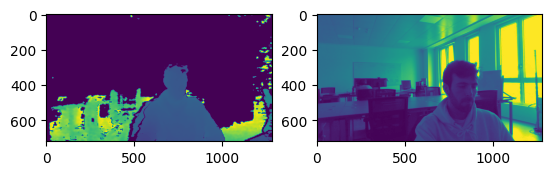

In [21]:
import math
import itertools

rgbd_image, intr = acquire(False)
plt.subplot(1,2,1)
plt.imshow(rgbd_image.depth)
plt.subplot(1,2,2)
plt.imshow(rgbd_image.color)

camera_intrinsic = o3d.camera.PinholeCameraIntrinsic(o3d.camera.PinholeCameraIntrinsic(
    intr.width, intr.height, intr.fx, intr.fy, intr.ppx, intr.ppy
))
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, camera_intrinsic)
bounds = [[-math.inf, math.inf], [-math.inf, math.inf], [0.1, 1]]  # set the bounds
bounding_box_points = list(itertools.product(*bounds))  # create limit points
bounding_box = o3d.geometry.AxisAlignedBoundingBox.create_from_points(o3d.utility.Vector3dVector(bounding_box_points))  # create bounding box object
pcd = pcd.crop(bounding_box)
o3d.visualization.draw_geometries([pcd])

Anche avendo la stessa risoluzione (1280x720) nelle 2 camere IR e quella RGB, non troviamo corrispondenza pixel-by-pixel tra le due immagini.
Questo è dovuto al posizionamento fisico dei sensori (displacement tra rgb e IR) e ai differenti Field Of View dei sensori.
RealSense mette a disposizione un metodo che permette di allineare le due immagini (traslazione e scala).

In [ ]:
import math
import itertools

rgbd_image, intr = acquire(True)
plt.subplot(1,2,1)
plt.imshow(rgbd_image.depth)
plt.subplot(1,2,2)
plt.imshow(rgbd_image.color)

camera_intrinsic = o3d.camera.PinholeCameraIntrinsic(o3d.camera.PinholeCameraIntrinsic(
    intr.width, intr.height, intr.fx, intr.fy, intr.ppx, intr.ppy
))
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, camera_intrinsic)
bounds = [[-math.inf, math.inf], [-math.inf, math.inf], [0.1, 1]]  # set the bounds
bounding_box_points = list(itertools.product(*bounds))  # create limit points
bounding_box = o3d.geometry.AxisAlignedBoundingBox.create_from_points(o3d.utility.Vector3dVector(bounding_box_points))  # create bounding box object
pcd = pcd.crop(bounding_box)
o3d.visualization.draw_geometries([pcd])

# Introduzione della seconda camera

### Perché una seconda camera?
Lo scopo è quello di raccogliere dettagli di una faccia 2.5D coprendo idealmente l'area compresa tra l'orecchio destro e sinistro.

## Setup di acquisizione

![](setup.jpg)

## I parametri
* Distanza delle due camere
* Rotazione delle due camere

Per raccogliere più dettagli possibili del volto dobbiamo far si che il volto da acquisire si trovi nell'intersezione dei due Field Of Views delle camere.
Data una configurazione di distanza e rotazione, dobbiamo impostare una distanza del soggetto tale per cui esso ricada nell'intersezione dei due FOV.

<div>
<img src="ParametriSetup.png" width="500"/>
</div>

Vogliamo far si che la distanza del soggetto dalle camere sia minima per ottenere una risoluzione spaziale massima -> Soggetto lontano pochi pixel rappresentano naso, soggetto vicino molti più pixel rappresentano la stessa porzione di soggetto.
Vorremmo camere laterali per l'acquisizione migliore dell'orecchio andando a perdere la parte frontale (3 camera o trade-off).



# Acquisizione delle point-cloud

Ogni ricostruirà una point cloud, queste dovranno poi essere fuse. 

* Camere sovrapposte: le point cloud corrisponderanno "perfettamente"
* Camere traslate
* Camere traslate e ruotate

# Solo traslazione

# Introduzione matrice roto traslazione per merge delle pointcloud

$$ M=\begin{bmatrix} 1 & 0 & 0 & t_X \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix}$$

<div width="100%" align="center">
<img src="traslazione.png" width='800px'>
</div>

In [ ]:
trans_init = np.asarray([[1.0, 0.0, 0.0, -0.335],
                         [0.0, 1.0, 0.0, 0.0],
                         [0.0, 0.0, 1.0, 0.0],
                         [0.0, 0.0, 0.0, 1.0]])

In [15]:
import open3d as o3d
import numpy as np
pcl = o3d.geometry.PointCloud()
pcl.points = o3d.utility.Vector3dVector((np.random.randn(500,3)
))
pcl.paint_uniform_color((1,0,0))

traslazione = np.asarray([[1.0, 0.0, 0.0, 10.0],
                         [0.0, 1.0, 0.0, 0.0],
                         [0.0, 0.0, 1.0, 0.0],
                         [0.0, 0.0, 0.0, 1.0]])

# Applico rototraslazione unica
transformed = o3d.geometry.PointCloud()
transformed.points = pcl.points
transformed.transform(traslazione)
transformed.paint_uniform_color((0,0,1))

o3d.visualization.draw_geometries([pcl, transformed])

In [16]:
# Applico prima rotazione e poi traslazione
traslazione = np.asarray([[1.0, 0.0, 0.0, -10.02],
                         [0.0, 1.0, 0.0, 0.0],
                         [0.0, 0.0, 1.0, 0.0],
                         [0.0, 0.0, 0.0, 1.0]])
transformed.transform(traslazione)
o3d.visualization.draw_geometries([pcl, transformed])

Oltre alla traslazione, come nel nostro esempio, dovremmo intervenire sulla matrice $R$ di rotazione.
A questo scopo occorre sapere come costruirla opportunamente.


# Matrici di rotazione

In matematica, e in particolare in geometria, una rotazione è una trasformazione del piano o dello spazio euclideo che sposta gli oggetti in modo rigido rispetto ad una retta chiamata asse di rotazione (in genere un asse del sistema di riferimento), di un angolo $\theta$  


Per evitare ambiguità, si fissa una direzione dell'asse, e si considera la rotazione dell'angolo $\theta$ effettuata in senso antiorario rispetto all'asse orientato. 

Ad esempio per definire una rotazione nello spazio 3D rispetto all'asse Y di un sistema di riferimento ortonormale, è possibile utilizzare una matrice 3x3 così definita: 

$$ R=\begin{bmatrix} \cos{\theta} & 0 & \sin{\theta} \\ 0 & 1 & 0 \\ -\sin{\theta} & 0 & \cos{\theta} \end{bmatrix}$$

Ad ogni punto verrà quindi applicata la precedente rotazione:
$$ \begin{bmatrix} x' \\ y' \\ z' \end{bmatrix}=\begin{bmatrix} \cos{\theta} & 0 & \sin{\theta} \\ 0 & 1 & 0 \\ -\sin{\theta} & 0 & \cos{\theta} \end{bmatrix}\begin{bmatrix} x \\ y \\ z \end{bmatrix}$$



# Applicato ai nostri dati


Finora abbiamo parlato di rotazione e traslazione applicate ai punti della point-cloud, ma questo risulta essere equivalente alla trasformazione che dobbiamo applicare al sistema di riferimento di una camera per spostarlo sull'altro.
È necessario quindi stabilire quale delle due camere prendere come riferimento primario, nel nostro caso si è scelta quella di sinistra.


<div width="50%" align="center">
<img src="setupconassi.png" width="100%" style="position: relative">
</div>
<div width="50%" align="center">
<img src="setup.png"  width="100%" style="position: relative">
</div>

<div width="100%" align="center">
<img src="rototraslazioneSetup.png">
</div>

Possiamo notare come i due sistemi di riferimento differiscano di 30 gradi ruotando intorno all'asse y.
Avendo la camera right come riferimento, considereremo come zero l'asse x della camera di destra. Considerando come verso di rotazione convenzionale quello antiorario, il sistema di riferimento della camera di sinistra è ruotato di -30° rispetto al sistema di riferimento primario.


<div width="100%" align="center">
<img src="nuovo.png">
</div>

Per allineare il sistema di riferimento secondario (sinistra) al primario (destra), occorre perciò ruotarlo di 30° intorno all'asse y.
La trasformazione appena definita verrà applicata ad ogni punto della point-cloud acquisita dalla camera secondaria, questo porterà ad avere una sovrapposizione delle due point cloud nel sistema di riferimento della camera primaria. 






# Traslazione e rotazione

In [ ]:
camera_intrinsic_left = o3d.camera.PinholeCameraIntrinsic(o3d.camera.PinholeCameraIntrinsic(
    intr.width, intr.height, intr.fx, intr.fy, intr.ppx, intr.ppy
))
camera_intrinsic_right = o3d.camera.PinholeCameraIntrinsic(o3d.camera.PinholeCameraIntrinsic(
    intr.width, intr.height, intr.fx, intr.fy, intr.ppx, intr.ppy
))

depth_raw_left = o3d.io.read_image("d_full_ex_l.png")
color_raw_left = o3d.io.read_image("c_full_ex_l.jpg")

rgbd_image_left = o3d.geometry.RGBDImage.create_from_color_and_depth(color_raw_left, depth_raw_left)

depth_raw_right = o3d.io.read_image("d_full_ex_r.png")
color_raw_right = o3d.io.read_image("c_full_ex_r.jpg")

rgbd_image_right = o3d.geometry.RGBDImage.create_from_color_and_depth(color_raw_right, depth_raw_right)

pcd_left = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image_left, camera_intrinsic_left)
pcd_right = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image_right, camera_intrinsic_right)

bounds = [[-math.inf, math.inf], [-math.inf, math.inf], [0.1, 1]]  # set the bounds
bounding_box_points = list(itertools.product(*bounds))  # create limit points
bounding_box = o3d.geometry.AxisAlignedBoundingBox.create_from_points(o3d.utility.Vector3dVector(bounding_box_points))  # create bounding box object

# Crop the point cloud using the bounding box:
pcd_left = pcd_left.crop(bounding_box)
pcd_right = pcd_right.crop(bounding_box)

# Primario -> Camera di destra 
# Secondario -> Camera di sinistra
angolo = -np.pi/3
trans_init = np.asarray([[np.cos(angolo), 0.0, np.sin(angolo), -0.34],
                         [0.0, 1.0, 0.0, 0.0],
                         [-np.sin(angolo), 0.0, np.cos(angolo), 0.0],
                         [0.0, 0.0, 0.0, 1.0]])
pcd_left.transform(trans_init)

pcd_left.paint_uniform_color((1,0,0))
pcd_right.paint_uniform_color((0,0,1))

o3d.visualization.draw_geometries([pcd_left, pcd_right])

# Come mai non c'è sovrapposizione perfetta?
La causa è da trovarsi nella scarsa precisione di posizionamento delle camere che porta ad avere parametri reali differenti da quelli teorici, e la conseguente matrice di rototraslazione. 
Per ovviare a questo problema è possibile utilizzare l'ICP (Iterative Closest Point), uno dei metodi di registrazione di point-cloud più utilizzati.


# ICP - Iterative Closest Point
<div>
<img src="icp.png">
</div>

In [51]:
import open3d as o3d
import numpy as np
pcl = o3d.geometry.PointCloud()
pcl.points = o3d.utility.Vector3dVector((np.random.randn(500,3)
))
pcl.paint_uniform_color((1,0,0))

angolo = -np.pi/2
rot_and_trasl = np.asarray([[np.cos(angolo), 0.0, np.sin(angolo), 10],
                         [0.0, 1.0, 0.0, 0.0],
                         [-np.sin(angolo), 0.0, np.cos(angolo), 0.0],
                         [0.0, 0.0, 0.0, 1.0]])

# Applico rototraslazione unica
transformed_rototraslazione = o3d.geometry.PointCloud()
transformed_rototraslazione.points = pcl.points
transformed_rototraslazione.transform(rot_and_trasl)
transformed_rototraslazione.paint_uniform_color((0,0,1))

o3d.visualization.draw_geometries([pcl, transformed_rototraslazione])

# Applico prima rotazione e poi traslazione
angolo = -np.pi/2
translation = np.asarray([[1.0, 0.0, 0.0, 10.05],
                         [0.0, 1.0, 0.0, 0.0],
                         [0.0, 0.0, 1.0, 0.0],
                         [0.0, 0.0, 0.0, 1.0]])

rotation = np.asarray([[np.cos(angolo), 0.0, np.sin(angolo), 0.0],
                         [0.0, 1.0, 0.0, 0.0],
                         [-np.sin(angolo), 0.0, np.cos(angolo), 0.0],
                         [0.0, 0.0, 0.0, 1.0]])
transformed_rot_trasl = o3d.geometry.PointCloud()
transformed_rot_trasl.points = pcl.points
transformed_rot_trasl.transform(rotation)
transformed_rot_trasl.transform(translation)

transformed_rototraslazione.paint_uniform_color((0,0,1))
transformed_rot_trasl.paint_uniform_color((1,0,0))



o3d.visualization.draw_geometries([transformed_rototraslazione, transformed_rot_trasl])